#  OCR (Optical Character Recognition) - Experimento
## Utilização das bibliotecas [opencv](https://opencv.org/) e  [Tesseract OCR](https://tesseract-ocr.github.io/) para o reconhecimento de texto em imagens e da biblioteca [JiWER](https://github.com/jitsi/jiwer) para cálculo de mérticas de perfomance

*   Mais detalhes sobre  o funcionamento dos algorítimos e das línguas nos quais o mesmo podem são utilizados são encontrados na [Tesseract documentation](https://tesseract-ocr.github.io/tessdoc/Data-Files)

*   Caso seja passado um arquivo .xlsx com as strings de target pode visualizar a perfonrmance do algorítimo



## Declaração de parâmetros e hiperparâmetros

Declare parâmetros com o botão  na barra de ferramentas.<br>
A variável `dataset` possui o caminho para leitura do arquivos importados na tarefa de "Upload de dados".<br>
Você também pode importar arquivos com o botão  na barra de ferramentas.

Para esse componente, a base de dados deve estar no seguinte formado:
- Arquivo CSV chamado dataset.csv contendo as colunas "image_path", "target" e "subset", entre outras, caso necessário. Onde:
    - image_path: caminho para o arquivo de imagem.
    - target: resposta esperada da predição, caso exista.
    - subset: conjunto ao qual a amostra faz parte, pode ser "train", "test", e "val". 
- Imagens coloridas (3 canais)
- Cada conjunto de treino, validação e teste possuem sua pasta com suas respectivas imagens. Um exemplo da árvore de diretórios pode ser observado abaixo:

```bash
dataset
|________dataset.csv
|________train
|        |__________image0.jpg
|        |__________image1.jpg
|        |__________image2.jpg
|        |__________image3.jpg
|               ...
|
|________val
|        |__________image4.jpg
|        |__________image5.jpg
|        |__________image6.jpg
|        |__________image7.jpg
|               ...
|
|________test
|        |__________image8.jpg
|        |__________image9.jpg
|        |__________image10.jpg
|        |__________image11.jpg
|              ...
```

In [1]:
dataset = "/tmp/data/ocr_dataset-2.zip" #@param {type:"string"}
image_path = "image_path" #@param {type:"string", label:"Caminho das imagens", description:"Coluna da tabela com o caminho para as imagens."}
target = "target" #@param {type:"string", label:"Atributo alvo", description:"Seu modelo tentará prever os valores do alvo."}

#Hyperparams 
bbox_conf = 60 #@param {type:"number",label:"Confiabilidade do bbox", description:"O quanto de confiabilidade o algorítmo deve possuir sobre o bbox para que o mesmo apareça."}

#Pytesseact Params
segmentation_mode = "Considere um único bloco de texto uniforme"  #@param ["Orientação e detecção de script (OSD) apenas","Segmentação automática de página com OSD","Segmentação automática de página, mas sem OSD ou OCR","Segmentação de página totalmente automática, mas sem OSD. (Padrão)","Considere uma única coluna de texto de tamanhos variáveis","Considere um único bloco uniforme de texto alinhado verticalmente","Considere um único bloco de texto uniforme","Trate a imagem como uma única linha de texto","Trate a imagem como uma única palavra","Trate a imagem como uma única palavra em um círculo","Trate a imagem como um único caractere","Texto esparso. Encontre o máximo de texto possível em nenhuma ordem específica","Texto esparso com OSD","Linha crua. Trate a imagem como uma única linha de texto, evitando hacks específicos do Tesseract"] {type:"string",label:"Modo de segmentação do PyTesseract", description:"Para mais informações acesse a documentação linkada no inicio do notebook"}
ocr_engine = "Mecanismo de redes neurais com apenas LSTM" #@param ["Apenas mecanismo legado","Mecanismo de redes neurais com apenas LSTM","Mecanismo legado + LSTM","Padrão, com base no que está disponível"] {type:"string",label:"Mecanismo OCR do Pytesseract",description:"Para mais informações acesse a documentação linkada no inicio do notebook"}
language = "português" #@param ["português","inglês"] {type:"string",label:"Idioma pré teinado",description:"Opções disponibilizadas na aplicação compreendem português e inglês."}

#Return formart
bbox_return = "np_array" #@param ["np_array","image"] {type:"string",label:"Forma de retorno dos bboxes",description:"Escolher se bboxes serão retornados na imagem ou como um numpy array"}
image_return_format = "N/A" #@param ["N/A",".jpg",".png"] {type:"string",label:"Formato de retorno da imagem caso bbox_return = image",description:"Escolher formato de retorno da imagem, N/A se retornar numpy array"}
remove_linebreaks = True #@param [True,False] {type:"boolean",label:"Remove quebras de linha",description:"Caso True remove \n e \t dos resultados.Vale ressaltar que o texto de referência na tabela .xlsx caso haja, deve considerar este fato para calcular as métricas corretamente"}

In [2]:
language = "por" if language == "português" else "eng"

In [3]:
translate_segmentation = {
    "Orientação e detecção de script (OSD) apenas" : "Orientation and script detection (OSD) only.",
    "Segmentação automática de página com OSD" : "Automatic page segmentation with OSD.",
    "Segmentação automática de página, mas sem OSD ou OCR" : "Automatic page segmentation, but no OSD, or OCR.",
    "Segmentação de página totalmente automática, mas sem OSD. (Padrão)" : "Fully automatic page segmentation, but no OSD. (Default)",
    "Considere uma única coluna de texto de tamanhos variáveis" : "Assume a single column of text of variable sizes.",
    "Considere um único bloco uniforme de texto alinhado verticalmente" : "Assume a single uniform block of vertically aligned text.",
    "Considere um único bloco de texto uniforme" : "Assume a single uniform block of text.",
    "Trate a imagem como uma única linha de texto" : "Treat the image as a single text line.",
    "Trate a imagem como uma única palavra" : "Treat the image as a single word.",
    "Trate a imagem como uma única palavra em um círculo" : "Treat the image as a single word in a circle.",
    "Trate a imagem como um único caractere" : "Treat the image as a single character.",
    "Texto esparso. Encontre o máximo de texto possível em nenhuma ordem específica" : "Sparse text. Find as much text as possible in no particular order.",
    "Texto esparso com OSD" : "Sparse text with OSD",
    "Linha crua. Trate a imagem como uma única linha de texto, evitando hacks específicos do Tesseract." : "Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.",
}

In [4]:
segmentation_mode = translate_segmentation[segmentation_mode]

In [5]:
translate_engine = {
    "Apenas mecanismo legado" : "Legacy engine only.",
    "Mecanismo de redes neurais com apenas LSTM" : "Neural nets LSTM engine only.",
    "Mecanismo legado + LSTM" : "Legacy + LSTM engines.",
    "Padrão, com base no que está disponível" : "Default, based on what is available.",
}

In [6]:
ocr_engine = translate_engine[ocr_engine]

## Acesso ao conjunto de dados

O conjunto de dados utilizado nesta etapa será o mesmo carregado através da plataforma.<br>
O tipo da variável retornada depende do arquivo de origem:
- [pandas.DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) para CSV e compressed CSV: .csv .csv.zip .csv.gz .csv.bz2 .csv.xz
- [Binary IO stream](https://docs.python.org/3/library/io.html#binary-i-o) para outros tipos de arquivo: .jpg .wav .zip .h5 .parquet etc

In [7]:
# Construct dataset folder name for unzipped files
folder = '.'.join(dataset.split('.')[:-1])

# Creating empty folder
!mkdir -p {folder}

# Extracting files
!unzip -o {dataset} -d {folder}

Archive:  /tmp/data/ocr_dataset-2.zip
  inflating: /tmp/data/ocr_dataset-2/dataset.csv  
  inflating: /tmp/data/ocr_dataset-2/test/complex_text1.jpg  
  inflating: /tmp/data/ocr_dataset-2/test/complex_text2.jpg  
  inflating: /tmp/data/ocr_dataset-2/test/motiv1.png  
  inflating: /tmp/data/ocr_dataset-2/test/motiv2.jpg  
  inflating: /tmp/data/ocr_dataset-2/test/motiv3.jpg  
  inflating: /tmp/data/ocr_dataset-2/test/no_text.jpg  


In [8]:
import pandas as pd

df = pd.read_csv(folder + '/dataset.csv')

df[image_path] = folder + df[image_path]

## Remoção de linhas com valores faltantes no atributo alvo
Caso haja linhas em que o atributo alvo contenha valores faltantes, é feita a remoção dos casos faltantes.


In [9]:
df.dropna(inplace=True) 

X = df[image_path].to_numpy()
y = df[target].to_numpy()

## Chamada da Classe de OCR

In [10]:
hyperparams = {'bbox_conf':bbox_conf}
model_parameters = {'ocr_engine':ocr_engine,'segmentation_mode':segmentation_mode,'language':language}
return_formats = {'bbox_return':bbox_return,'image_return_format':image_return_format, 'remove_linebreaks':remove_linebreaks}

In [11]:
from ocr import Class_Pytesseract_OCR

model = Class_Pytesseract_OCR(hyperparams, model_parameters,return_formats)
df = model.get_result_dataframe(X, y)

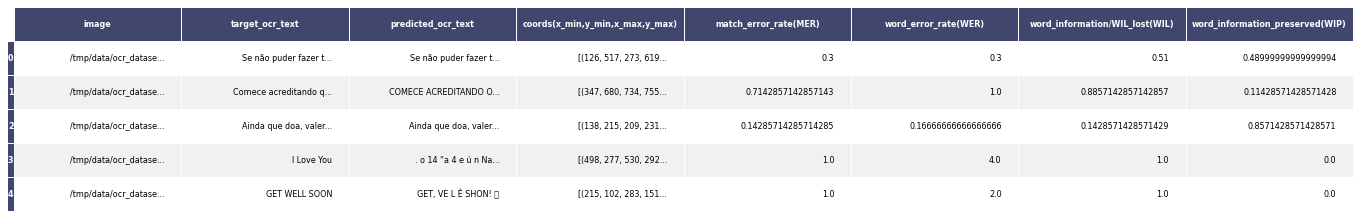

In [12]:
import matplotlib.pyplot as plt
from platiagro.plotting import plot_data_table

ax = plot_data_table(df)
plt.show()

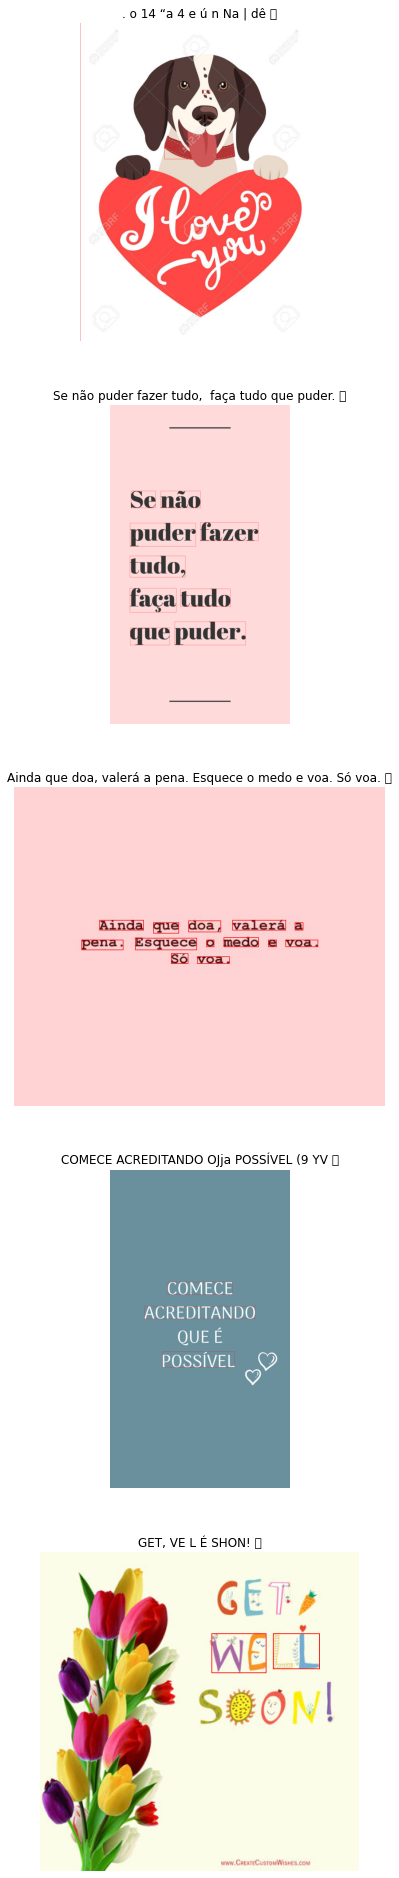

In [39]:
# Drawing sample results

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image, ImageDraw
from draws import draw_bboxes_without_text

# Select a sample of uniques to show results
uniques = np.random.choice(X,  min(len(X), 5), replace=False)

fig, axies = plt.subplots(len(uniques), figsize=(36, 34))

for i, unique in enumerate(uniques):
    frame = np.array(Image.open(unique).convert('RGB'))
    
    unique_df = df[df['image'] == unique]
    bboxes = unique_df['coords(x_min,y_min,x_max,y_max)'].values[0]
    
    img = draw_bboxes_without_text(frame, bboxes)

    axies[i].axis('off')
    axies[i].set_title(unique_df['predicted_ocr_text'].values[0])
    axies[i].imshow(img)


## Salva métricas

Utiliza a função `save_metrics` do [SDK da PlatIAgro](https://platiagro.github.io/sdk/) para salvar as métricas:`MER`, `WER`, `WIL`, `WIP` <br>


In [40]:
from platiagro import save_metrics

save_metrics(MER=model.avg_mer, WER=model.avg_wer, WIL=model.avg_wil, WIP=model.avg_wip)

## Salva resultados da tarefa 

A plataforma guarda o conteúdo de `/tmp/data/` para as tarefas subsequentes.

In [41]:
from joblib import dump

artifacts = {
    "hyperparams": hyperparams,
    "model_parameters": model_parameters,
    "return_formats":return_formats
}

dump(artifacts, "/tmp/data/ocr.joblib")

['/tmp/data/ocr.joblib']